In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
#import os

#import string

%matplotlib inline

In [30]:
# Read in the saved files
directory = 'Binned_results/'

files = glob.glob('Binned_results/*.csv')
all_frames_lst = []

for file in files:
    frame = pd.read_csv(file)
    all_frames_lst.append(frame)
    
master_raw = pd.concat(all_frames_lst)
master_raw.Period = master_raw.Period / 3 # Convert period to unit of hour

# Convert to actual length units
perch_sep_pix = 230.0 - 60.0 # perch distance in pixels based on image
perch_sep_m = 8.5 / 100 # actual perch distance

master_raw.Activity = master_raw.Activity / perch_sep_pix * perch_sep_m

# Determine genotype

def get_genotype(animal):
    '''Infer the genotype from name of animal'''
    if animal == '2CW318' or animal == 'LB21':
        return 'NA'
    elif '2CW' in animal:
        return 'mut'
    elif 'Z1' in animal:
        return 'Other'
    else:
        return 'WT'
    
def build_gen_dict(animal_lst):
    '''
    Given a list of animal names, use get_genotype
    to return a dict of collections genotype <-> animals of that genotype
    For eg. 'WT' : ['LB2', 'Or130'], 'mut' : ['2CW318', '2CW317']
    '''
    gen_dict = {}
    for animal in animals_lst:
        genotype = get_genotype(animal)
        if genotype not in gen_dict:
            gen_dict[genotype] = [animal]
        else:
            gen_dict[genotype].append(animal)
    return gen_dict
    

master_raw['Genotype'] = master_raw.Animal.apply(get_genotype)

# Exclude days
def get_membership(number, lst):
    return number in lst

days_to_exclude = {'2CW318': [3],
                  'LB21': [0],
                  '2CW312': [-1, 0, 1],
                  'LB15': [-1, 0]}

master = master_raw
for animal in days_to_exclude:
    master = master[(master.Animal != animal) | (~master.Day.isin(days_to_exclude[animal]))]

# Get number of animals
animals_lst = pd.Series(master.Animal.unique())
gen_dict = build_gen_dict(animals_lst)
ntotal = animals_lst.shape[0]
n_wt = len(gen_dict['WT'])
n_mut = len(gen_dict['mut'])
n_other = len(gen_dict['Other'])

print 'Total =', ntotal, '. WT =', n_wt, '. Mut =', n_mut, '. Other =', n_other

Total = 17 . WT = 7 . Mut = 6 . Other = 2


In [31]:
gen_dict

{'NA': ['2CW318', 'LB21'],
 'Other': ['Z1Pi229', 'Z1Pi230'],
 'WT': ['LB06', 'LB11', 'LB15', 'LB2', 'Or114', 'Or128', 'Or130'],
 'mut': ['2CW100', '2CW305', '2CW306', '2CW308', '2CW312', '2CW317']}

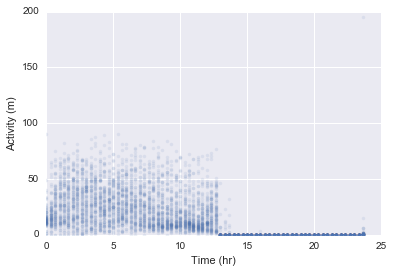

In [32]:
plt.plot(master.Period, master.Activity, '.', alpha=0.1)
plt.xlabel('Time (hr)')
plt.ylabel('Activity (m)')

In [33]:
# Get average activity for each animal
mean_fr = master.groupby(['Animal','Period']).mean()['Activity']
mean_fr = mean_fr.reset_index()



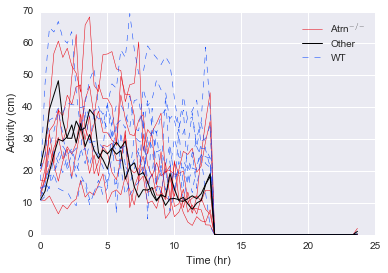

In [34]:
# Define a color palette to use for plots
col_lst = {'WT': sns.color_palette('bright')[0],
          'mut': sns.color_palette('bright')[2],
          'Other': (0, 0, 0)}

# Plot
for animal in mean_fr.Animal.unique():
    animal_fr = mean_fr[mean_fr.Animal == animal]
    if animal in gen_dict['mut']: # mutant
        atrn_line = plt.plot(animal_fr.Period, animal_fr.Activity, 
                             alpha=1, color=col_lst['mut'], lw=0.5)
    elif animal in gen_dict['Other']: # other
        other_line = plt.plot(animal_fr.Period, animal_fr.Activity, 
                           alpha=1, color=col_lst['Other'], lw=1)
    elif animal in gen_dict['WT']: # Wild-type
        wt_line = plt.plot(animal_fr.Period, animal_fr.Activity, '--', 
                              alpha=1, color=col_lst['WT'], lw=0.5)
        
plt.xlabel('Time (hr)')
plt.ylabel('Activity (cm)')
plt.legend()
plt.legend((atrn_line[0], other_line[0], wt_line[0]), ('Atrn$^{-/-}$','Other','WT'))
        

In [35]:
# Get 'average line' for wt, mutant, other
mean_fr['Genotype'] = mean_fr.Animal.apply(get_genotype)
genotype_mean_fr = mean_fr.groupby(['Genotype', 'Period']).mean()
genotype_mean_fr = genotype_mean_fr.reset_index()

# Get standard deviation
stdev = mean_fr.groupby(['Genotype', 'Period']).std()
stdev = stdev.reset_index()



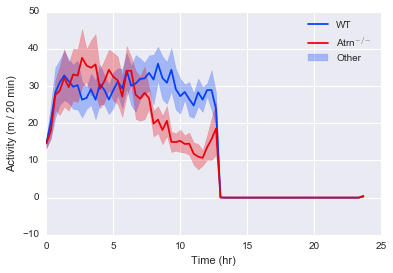

In [36]:
# Plot mean lines
#with sns.color_palette('bright'):
for gtype in ['WT', 'mut']:
    fr = genotype_mean_fr[genotype_mean_fr.Genotype == gtype]
    stdev_genotype = stdev[stdev.Genotype == gtype].Activity
    std_err = stdev_genotype / np.sqrt(len(gen_dict[gtype]))

    plt.plot(fr.Period, fr.Activity, color=col_lst[gtype])
    plt.fill_between(fr.Period, fr.Activity + std_err, fr.Activity - std_err, 
                     alpha=0.3, color=col_lst[gtype])
plt.legend(('WT', 'Atrn$^{-/-}$', 'Other'))
plt.xlabel('Time (hr)')
plt.ylabel('Activity (m / 20 min)')

In [57]:
def ind_animal_plot(master, name, exclude=[]):
    fr = master[(master.Animal == name) & (~master.Day.isin(exclude))]
    for day in fr.Day.unique():
        subfr = fr[fr.Day == day]
        plt.plot(subfr.Period, subfr.Activity, alpha=0.3, label='Day' + str(day))

    # Plot the mean line
    mean_animal_fr = fr.groupby('Period').mean()
    mean_animal_fr = mean_animal_fr.reset_index()
    plt.plot(mean_animal_fr.Period, mean_animal_fr.Activity, '--', 
             color='black', label='Mean')
    
    plt.ylim((0, 80))

    plt.xlabel('Time (hour)')
    plt.ylabel('Activity')
    plt.legend()

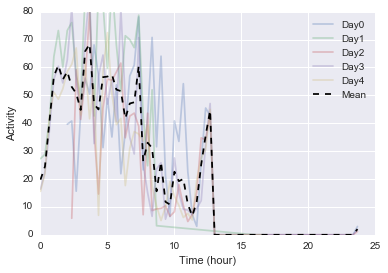

In [58]:
ind_animal_plot(master, '2CW100', exclude=[])

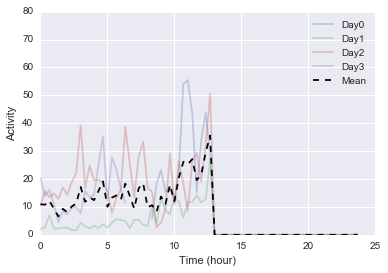

In [59]:
ind_animal_plot(master, '2CW305', exclude=[])

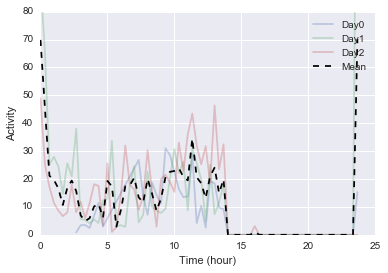

In [60]:
ind_animal_plot(master, '2CW318', exclude=[3])

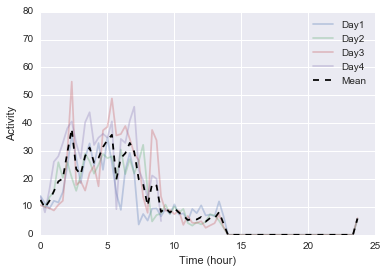

In [61]:
ind_animal_plot(master, 'LB21', exclude=[])

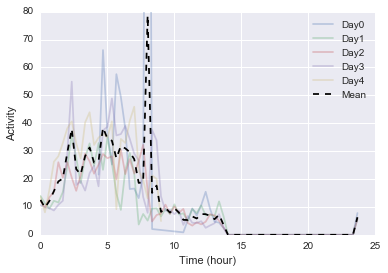

In [62]:
ind_animal_plot(master_raw, 'LB21', exclude=[])

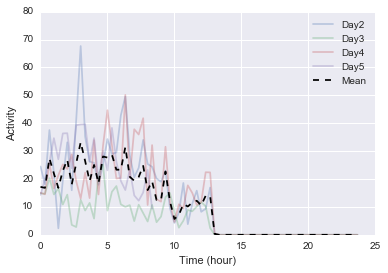

In [63]:
ind_animal_plot(master, '2CW312', exclude=[])

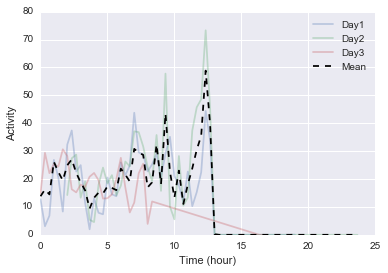

In [64]:
ind_animal_plot(master, 'LB15', exclude=[])

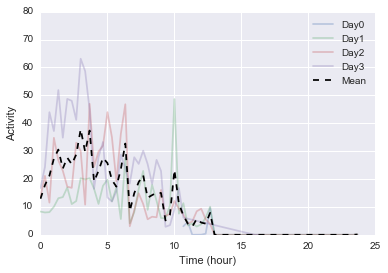

In [65]:
ind_animal_plot(master, '2CW306', exclude=[])

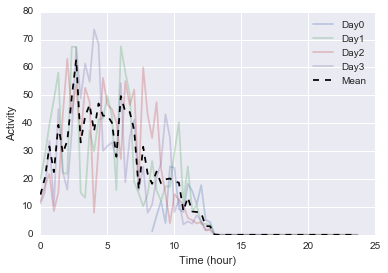

In [66]:
ind_animal_plot(master, '2CW308', exclude=[])

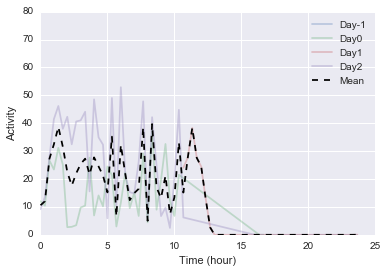

In [67]:
ind_animal_plot(master, 'LB06', exclude=[])

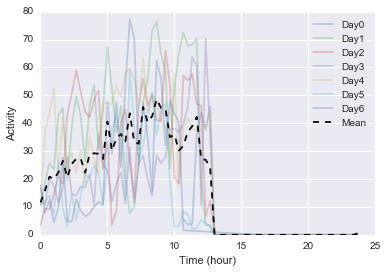

In [68]:
ind_animal_plot(master, 'Or130', exclude=[])

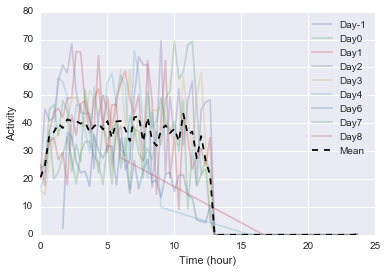

In [69]:
ind_animal_plot(master, 'Or114', exclude=[])

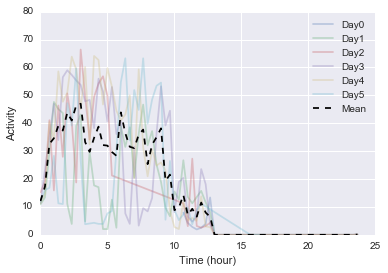

In [70]:
ind_animal_plot(master, '2CW317', exclude=[])

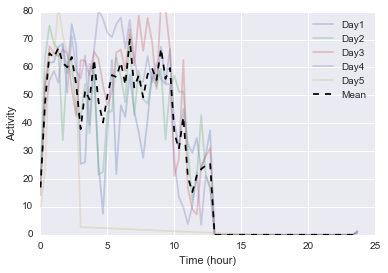

In [71]:
ind_animal_plot(master, 'LB2', exclude=[0])

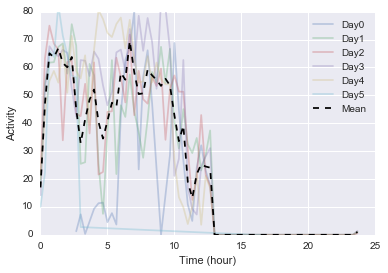

In [72]:
ind_animal_plot(master, 'LB2', exclude=[])

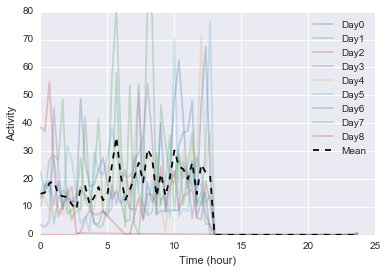

In [73]:
ind_animal_plot(master, 'LB11', exclude=[])

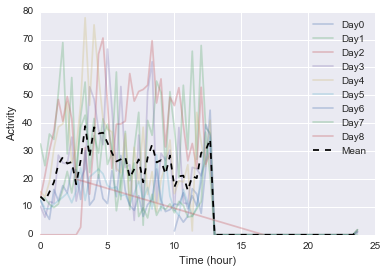

In [74]:
ind_animal_plot(master, 'Or128', exclude=[])

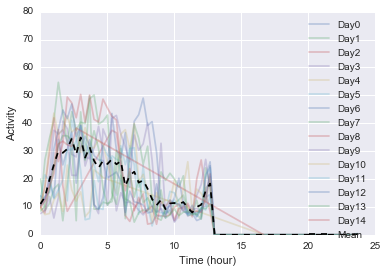

In [75]:
ind_animal_plot(master, 'Z1Pi229', exclude=[])

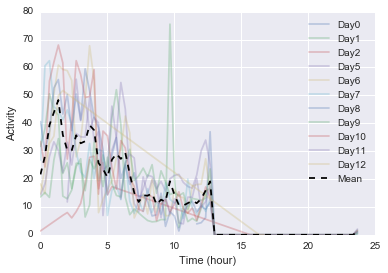

In [76]:
ind_animal_plot(master, 'Z1Pi230', exclude=[])